In [3]:
import os
import urllib.request

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dbfread import DBF
from pandas import DataFrame
import seaborn as sns
from ortools.linear_solver import pywraplp


# Wind turbine optimization

## 0 - Importing data

In [4]:
"""
Load content of a DBF file into a Pandas data frame.

The iter() is required because Pandas doesn't detect that the DBF
object is iterable.

Loading the raw geospatial data into a Pandas data frame.

Datasource: https://www.swisstopo.admin.ch/en/home/meta/supply-structure/freely-available.html
"""

# Downloading a file from remote to a local file in a folder called Geospatial_raw_data_remote
dbf_url = 'https://github.com/percw/Swiss_wind-turbine_optimization/raw/b23d047c6f824bb225cc1b7d5aa559166f191ec6/Geospatial_raw_data/spat_pts/spat_pts.dbf'
shape_url = 'https://github.com/percw/Swiss_wind-turbine_optimization/raw/b23d047c6f824bb225cc1b7d5aa559166f191ec6/Geospatial_raw_data/spat_pts/spat_pts.shp'


# Checking if the folder Geospatial_raw_data exists, if not: downloading the files from remote
if not os.path.exists('./Geospatial_raw_data/'):
	os.makedirs('./Geospatial_raw_data/spat_pts/')
	urllib.request.urlretrieve(dbf_url, './Geospatial_raw_data/spat_pts.dbf') 		# Loading the .dbf file
	urllib.request.urlretrieve(shape_url, './Geospatial_raw_data/spat_pts.shp') 	# Loading the .shp file

# Loading the file from local to Geopandas and Pandas data frame
dbf = DBF('./Geospatial_raw_data/spat_pts.dbf', encoding='UTF-8')
gdf = gpd.read_file('./Geospatial_raw_data/spat_pts.shp')
df_dbf_raw = DataFrame(iter(dbf))



File: `spat_pts.dbf` - consists of candidate wind turbine locations in Switzerland which are technically feasible. The readme file provides details about the 30 attributes further attributes and the coordinate reference system. 

In [5]:
print(df_dbf_raw.head(10))
#print(df_shp_raw.head(10))

# Displaying the column names of the dbf file
print(df_dbf_raw.columns)

    PU_ID   LT  WT_ID  DIST_ISOS  DIST_UNE_N  DIST_UNE_K  DIST_BLN  DIST_VAEW  \
0   738.0  1.0    9.0      735.0    132448.0     16505.0     184.0   115789.0   
1   880.0  1.0   11.0      567.0    132177.0     16475.0     382.0   115340.0   
2   881.0  1.0   12.0      186.0    131844.0     15740.0     156.0   115343.0   
3  1021.0  1.0   15.0      424.0    131912.0     16340.0     389.0   114896.0   
4  1163.0  1.0   20.0     1288.0    131652.0     16255.0     349.0   114458.0   
5  1449.0  1.0   24.0      767.0    130084.0     14166.0     412.0   113543.0   
6  1586.0  1.0   25.0      940.0    131307.0     17251.0     650.0   113249.0   
7  1589.0  1.0   28.0     1856.0    130159.0     14700.0     223.0   113097.0   
8  1590.0  1.0   29.0      636.0    129811.0     14094.0     387.0   113089.0   
9  1591.0  1.0   30.0      847.0    129481.0     13388.0     225.0   113102.0   

   DIST_RAD  DIST_AIR  ...  COHER_AREA  VIS_ARE_ha  ENER_DENS     DIST_NATPA  \
0   26065.0    2861.0  ...  

## 1 - Discovering the data 

In [6]:

print(f'Number of technically possible wind turbine locations: {len(df_dbf_raw["PU_ID"].unique())}')
print(f'Number of canton where its feasible to place wind turbine: {len(df_dbf_raw["CANT_NAME"].unique())}')
print(f'The cantons are: {df_dbf_raw["CANT_NAME"].unique()}')

Number of technically possible wind turbine locations: 12238
Number of canton where its feasible to place wind turbine: 27
The cantons are: ['GenÃ¨ve' 'Vaud' 'NeuchÃ¢tel' 'Fribourg' 'Valais' 'Bern' 'Jura'
 'Solothurn' 'Basel-Landschaft' 'Basel-Stadt' 'Aargau' 'Luzern' 'Obwalden'
 'Nidwalden' 'ZÃ¼rich' 'Zug' 'Schaffhausen' 'Schwyz' 'Uri' 'Thurgau'
 'Ticino' 'St. Gallen' 'Glarus' 'GraubÃ¼nden' 'Appenzell Ausserrhoden'
 'Appenzell Innerrhoden' '']


Checking out the canton with the empty string

In [7]:
display(df_dbf_raw[df_dbf_raw["CANT_NAME"] == ''])

,PU_ID,LT,WT_ID,DIST_ISOS,DIST_UNE_N,DIST_UNE_K,DIST_BLN,DIST_VAEW,DIST_RAD,DIST_AIR,...,COHER_AREA,VIS_ARE_ha,ENER_DENS,DIST_NATPA,STRE_ALTI,DIST_REG_N,weigh_stre,prod_MW,KIBK,CANT_NAME
11483,44486.0,3.0,90016.0,4448.0,103730.0,25509.0,1211.0,118303.0,110823.0,4602.0,...,0.060856,16516.0,0.17994,240473.993717,884.0,0.0,669.999901,8173.304396,4.0,


Investigating the shapefile

In [8]:
display(gdf.columns)
display(gdf.head())

Index(['PU_ID', 'LT', 'WT_ID', 'DIST_ISOS', 'DIST_UNE_N', 'DIST_UNE_K',
       'DIST_BLN', 'DIST_VAEW', 'DIST_RAD', 'DIST_AIR', 'DIST_MIL',
       'DIST_FLOOD', 'DIST_MEAD', 'DIST_JB', 'DIST_BIOS', 'DIST_STRE',
       'DIST_FOR', 'DIST_HZ', 'DIST_IZ', 'DIST_PL', 'DIST_BUILD', 'ALTI',
       'NOISE', 'FFF', 'VIS_AREA', 'VIS_IMPACT', 'VIS_INFRA', 'VIS_POP',
       'COHER_AREA', 'VIS_ARE_ha', 'ENER_DENS', 'DIST_NATPA', 'STRE_ALTI',
       'DIST_REG_N', 'weigh_stre', 'prod_MW', 'KIBK', 'CANT_NAME', 'geometry'],
      dtype='object')

,PU_ID,LT,WT_ID,DIST_ISOS,DIST_UNE_N,DIST_UNE_K,DIST_BLN,DIST_VAEW,DIST_RAD,DIST_AIR,...,VIS_ARE_ha,ENER_DENS,DIST_NATPA,STRE_ALTI,DIST_REG_N,weigh_stre,prod_MW,KIBK,CANT_NAME,geometry
0,738.0,1.0,9.0,735.0,132448.0,16505.0,184.0,115789.0,26065.0,2861.0,...,28132.0,0.405058,314835.059489,457.0,24717.649525,219.999966,11395.094829,4.0,GenÃ¨ve,POINT (487660.175 118136.448)
1,880.0,1.0,11.0,567.0,132177.0,16475.0,382.0,115340.0,26638.0,1965.0,...,29088.0,0.400389,314505.331052,455.0,25089.914492,111.000053,11646.518761,4.0,GenÃ¨ve,POINT (488110.175 117357.025)
2,881.0,1.0,12.0,186.0,131844.0,15740.0,156.0,115343.0,25176.0,3242.0,...,27704.0,0.397480,314276.488429,432.0,23823.745962,160.000017,11011.797909,2.0,GenÃ¨ve,POINT (488110.175 118915.871)
3,1021.0,1.0,15.0,424.0,131912.0,16340.0,389.0,114896.0,27229.0,1068.0,...,28600.0,0.395229,314177.833777,419.0,25488.529743,111.000031,11303.539758,1.0,GenÃ¨ve,POINT (488560.175 116577.603)
4,1163.0,1.0,20.0,1288.0,131652.0,16255.0,349.0,114458.0,27836.0,171.0,...,28680.0,0.417131,313852.574631,377.0,25912.279012,785.999983,11963.309177,3.0,GenÃ¨ve,POINT (489010.175 115798.180)


## 2 - Visualisation

Creating subplot maps over the different columns to show how the different characteristics such as power, closest distance to nearest house etc for the technically plausible wind turbine locations in Switzerland looks like.

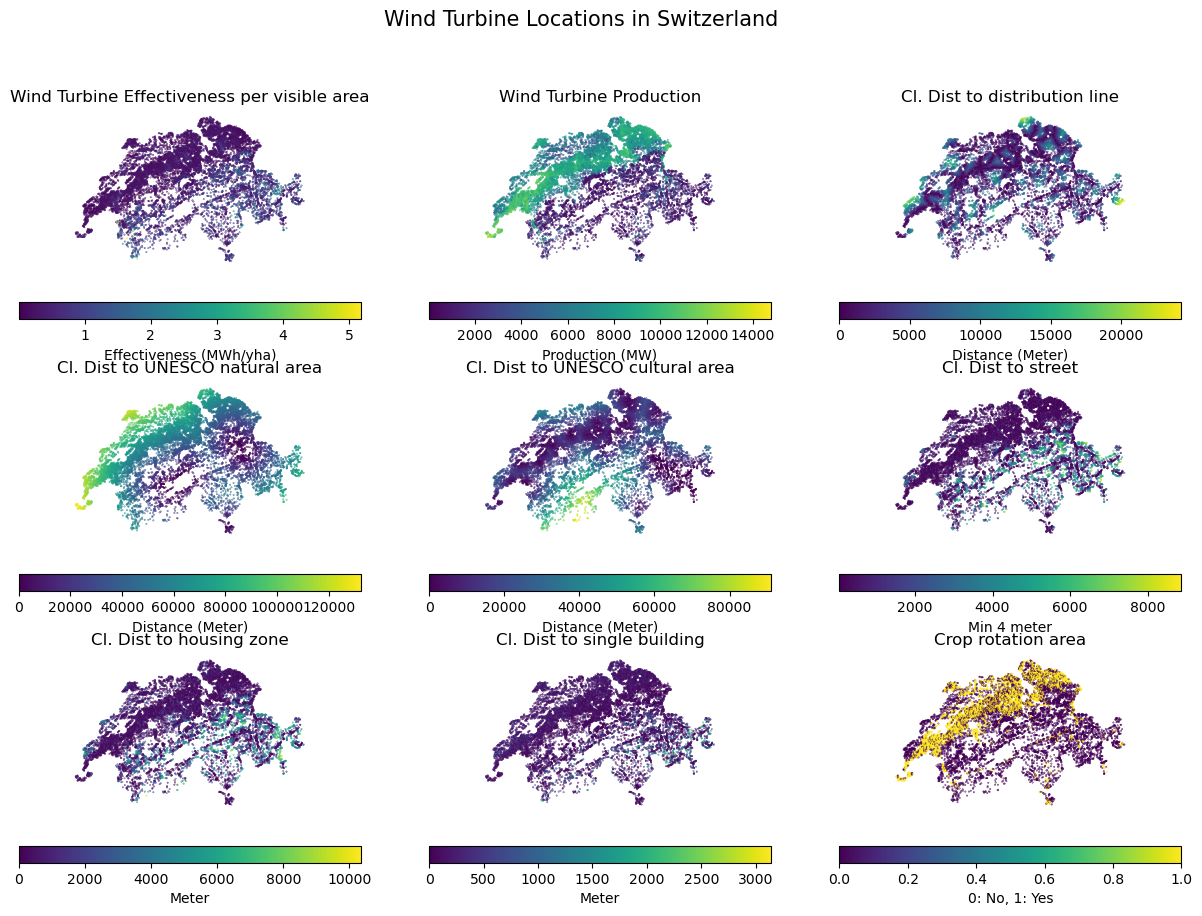

In [9]:

def create_subplot(gdf, columns, labels, titles, main_title, markersize=0.1, cmap='viridis', figsize=(15, 10)):
    fig, axes = plt.subplots(3, 3, figsize=figsize)
    axes = axes.flatten()  # flatten the 2D array to 1D for easier looping

    # log format the subplot coming from column 'ENER_DENS'

    for i in range(len(columns)):
        gdf.plot(column=columns[i], ax=axes[i], markersize=markersize, cmap=cmap, legend=True, legend_kwds={
            'label': labels[i], 'orientation': "horizontal"})
        axes[i].set_title(titles[i])
        axes[i].set_axis_off()

    if main_title:  # add a main title to the figure if provided
        fig.suptitle(main_title, size=15)


# Calling function to create a subplot
columns = ['ENER_DENS', 'prod_MW', 'DIST_PL', 'DIST_UNE_N', 'DIST_UNE_K',
           'DIST_STRE', 'DIST_HZ', 'DIST_BUILD', 'FFF']
labels = ["Effectiveness (MWh/yha)", "Production (MW)", "Distance (Meter)", "Distance (Meter)", "Distance (Meter)", "Min 4 meter",
          "Meter", "Meter", "0: No, 1: Yes"]
titles = ["Wind Turbine Effectiveness per visible area", "Wind Turbine Production", "Cl. Dist to distribution line",
          "Cl. Dist to UNESCO natural area", "Cl. Dist to UNESCO cultural area",
          "Cl. Dist to street", "Cl. Dist to housing zone", "Cl. Dist to single building", "Crop rotation area"]

create_subplot(gdf, columns, labels, titles,
               main_title="Wind Turbine Locations in Switzerland")


Plotting a correlation matrix between the different parameters

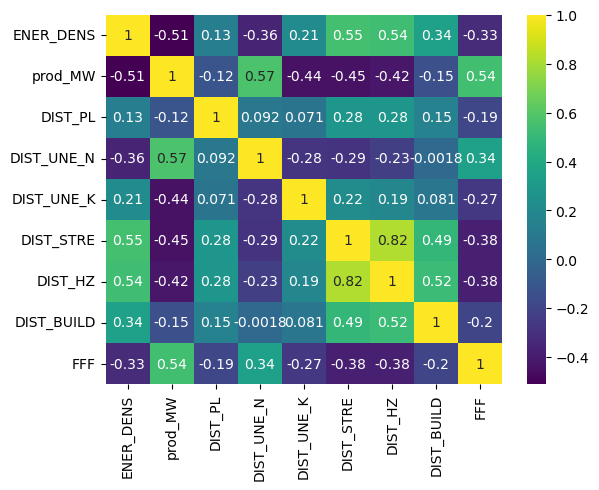

In [10]:

corr = gdf[columns].corr()

sns.heatmap(corr, annot=True, cmap='viridis')
plt.show()


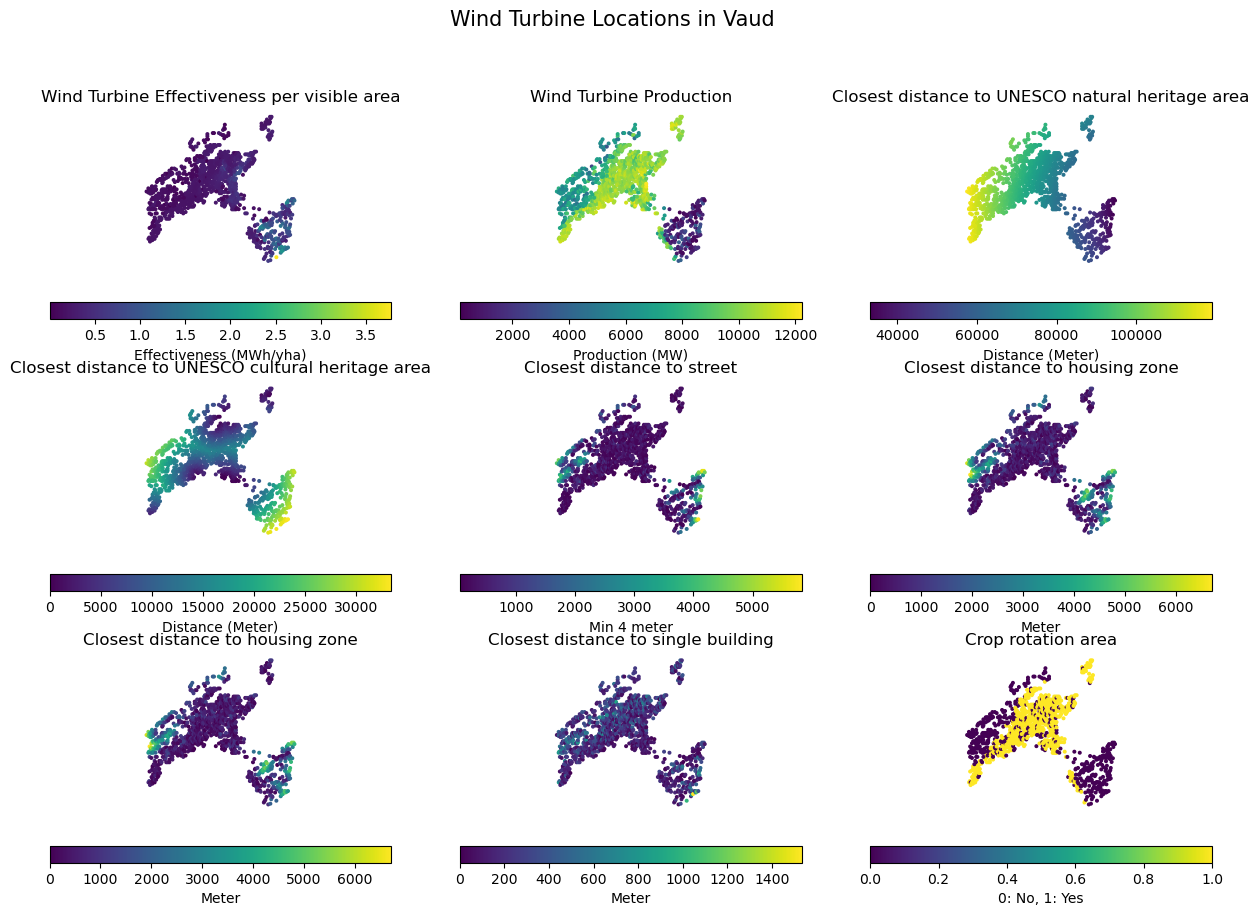

In [11]:
# Creating a figure with six subplots

gdf_vaud = gdf[gdf['CANT_NAME'] == 'Vaud'].copy()

# Calling function to create a subplot
columns = ['ENER_DENS', 'prod_MW', 'DIST_UNE_N', 'DIST_UNE_K',
           'DIST_STRE', 'DIST_HZ', 'DIST_HZ', 'DIST_BUILD', 'FFF']
labels = ["Effectiveness (MWh/yha)", "Production (MW)", "Distance (Meter)", "Distance (Meter)", "Min 4 meter",
          "Meter", "Meter", "Meter", "0: No, 1: Yes"]
titles = ["Wind Turbine Effectiveness per visible area", "Wind Turbine Production",
          "Closest distance to UNESCO natural heritage area", "Closest distance to UNESCO cultural heritage area",
          "Closest distance to street", "Closest distance to housing zone",
          "Closest distance to housing zone", "Closest distance to single building", "Crop rotation area"]

create_subplot(gdf_vaud, columns, labels, titles,
               main_title="Wind Turbine Locations in Vaud", markersize=3.5)


In [30]:
gdf_vaud

,PU_ID,LT,WT_ID,DIST_ISOS,DIST_UNE_N,DIST_UNE_K,DIST_BLN,DIST_VAEW,DIST_RAD,DIST_AIR,...,VIS_ARE_ha,ENER_DENS,DIST_NATPA,STRE_ALTI,DIST_REG_N,weigh_stre,prod_MW,KIBK,CANT_NAME,geometry
35,4581.0,1.0,145.0,4434.0,118209.0,5342.0,103.0,104465.0,11379.0,4026.0,...,55364.0,0.192633,301086.863909,477.0,7094.380529,320.999912,10664.948813,4.0,Vaud,POINT (499810.175 131386.637)
39,4723.0,1.0,157.0,4298.0,117667.0,5896.0,97.0,104089.0,10748.0,4419.0,...,54672.0,0.196790,300554.319018,480.0,6206.756382,375.999960,10758.880055,4.0,Vaud,POINT (500260.175 132166.060)
43,4864.0,1.0,165.0,3393.0,117526.0,3550.0,1827.0,103423.0,13117.0,2626.0,...,59084.0,0.192743,300367.913389,446.0,8342.530869,362.999912,11388.028438,4.0,Vaud,POINT (500710.175 129827.791)
44,4865.0,1.0,166.0,3575.0,117317.0,5012.0,874.0,103569.0,11627.0,3585.0,...,57224.0,0.191794,300192.454416,470.0,6821.864033,164.000053,10975.196267,3.0,Vaud,POINT (500710.175 131386.637)
46,5006.0,1.0,173.0,2951.0,116973.0,4136.0,1657.0,103054.0,12509.0,2751.0,...,58612.0,0.191944,299832.314387,443.0,7494.774097,661.999978,11250.204831,4.0,Vaud,POINT (501160.175 130607.214)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11330,36562.0,3.0,89751.0,2745.0,61724.0,1331.0,3827.0,55420.0,50186.0,16704.0,...,24480.0,0.145225,244131.293467,745.0,5423.218020,497.000249,9394.227855,4.0,Vaud,POINT (555410.175 149226.760)
11331,36568.0,3.0,89752.0,2370.0,62483.0,7420.0,9610.0,59265.0,52647.0,15800.0,...,20920.0,0.166220,243777.716939,763.0,10409.842289,289.999778,9179.784796,5.0,Vaud,POINT (555410.175 156501.374)
11373,39482.0,3.0,89822.0,4388.0,56131.0,6212.0,6318.0,50583.0,44827.0,14135.0,...,11352.0,0.169946,238543.024396,1183.0,1502.355779,1082.999794,5778.522468,5.0,Vaud,POINT (561010.175 149226.760)
11379,39661.0,3.0,89829.0,2453.0,55726.0,6901.0,3053.0,48170.0,43371.0,14340.0,...,19956.0,0.116278,238507.382222,1103.0,0.000000,877.999086,6747.197416,1.0,Vaud,POINT (561360.175 144983.236)


## 3 Optimization

### 3.1 Minimizing the number of wind turbines while reaching 1.2TWh per year in total production


#### Problem Formulation 

This document provides a mathematical formulation for a specific optimization problem. The problem aims to minimize the number of wind turbines while ensuring a total power production of at least 1.2 TWh/yha.

#### Decision Variables 

Let's denote the binary decision variables with the letter $x$. Each $x_{i}$ represents whether a wind turbine is placed at location $i$ or not. If a wind turbine is placed at location $i$, $x_{i}$ will be 1, otherwise, it will be 0.

$x_{i} \in \{0, 1\}$ for each $i \in I$, where $I$ is the set of all locations.

#### Constraints 

The problem has a constraint on the total power production. The sum of the power production from all locations where wind turbines are placed should be at least 1.2 TWh/yha. 

Let $p_{i}$ represent the power production in MW from location $i$.

This can be mathematically represented as:

$\sum_{i \in I} x_{i} * p_{i} \geq 1200000$

#### Objective Function 

The objective is to minimize the total number of wind turbines, which is equivalent to the sum of the decision variables $x_{i}$.

This can be mathematically represented as:

$Minimize: \sum_{i \in I} x_{i}$

#### Solution 

The solution is a vector $x$ that satisfies the constraint and minimizes the objective function. If there is no such vector, the problem does not have an optimal solution.

In [148]:
# 1. Set up the solver
solver = pywraplp.Solver.CreateSolver('SCIP')

# 2. Define decision variables
x = {}
for i in range(len(gdf)):
    x[i] = solver.IntVar(0, 1, '')

# 3. Define the constraint: total production should be 1.2 TWh/yha or more
solver.Add(sum(x[i] * gdf.prod_MW[i] for i in range(len(gdf))) >= 1200000)

# 4. Define the objective function. 
# Objective function: Minimize the number of wind turbines
solver.Minimize(solver.Sum(x[i] for i in range(len(gdf))))

status = solver.Solve()

# 6. Print the solution
if status == pywraplp.Solver.OPTIMAL:
    selected_locations = []
    total_output = 0
    for i in range(len(gdf)):
        if x[i].solution_value() > 0:
            selected_locations.append(gdf.iloc[i]['geometry'])
            total_output = total_output + gdf.iloc[i]['prod_MW']
    print(f'Number of wind turbines needed: {len(selected_locations)}')
    print(f'Power output: {total_output} MWh/y')
    print(f'Avg power output: {total_output/len(selected_locations)} MWh/y')

else:
    print('The problem does not have an optimal solution.')


Number of wind turbines needed: 101
Power output: 1209158.0 MWh/y
Avg power output: 11971.861386138615 MWh/y


Text(0.5, 1.0, 'Wind Turbine (WT) Locations in Switzerland \n (With the minimum number of WTs)')

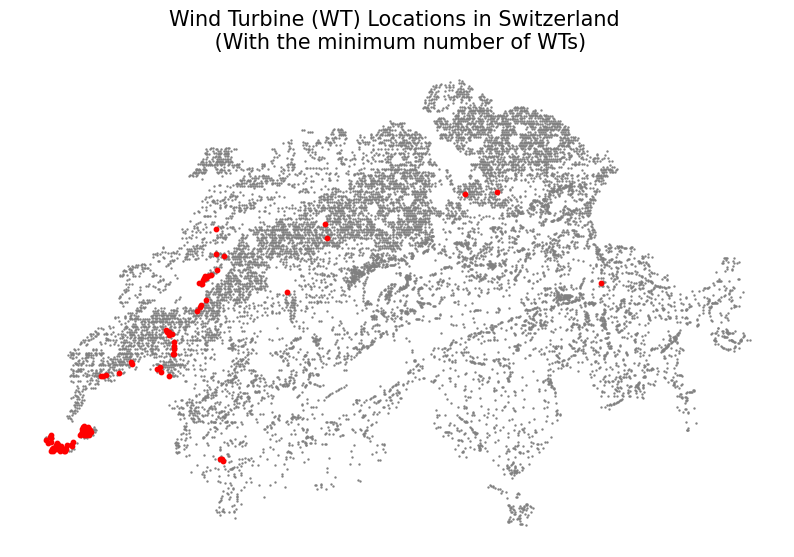

In [149]:
# Creating a new GeoDataFrame from selected locations
selected_gdf = gpd.GeoDataFrame(geometry=selected_locations)

# Ploting the selected locations on the map
ax = gdf.plot(color='grey', markersize=0.5, figsize=(10,10))
selected_gdf.plot(ax=ax, marker='o', color='red', markersize=10)

# Removing axis labels
ax.set_axis_off()

# Setting title
ax.set_title('Wind Turbine (WT) Locations in Switzerland \n (With the minimum number of WTs)', size=15)

### 3.2 Maximizing the energy output per visible area

### Problem Formulation 

This document provides a mathematical formulation for a specific optimization problem. The problem aims to minimize the number of wind turbines and maximize the energy density (ENER_DENS) while ensuring a total power production of at least 1.2 TWh/yha. 

### Decision Variables 

Let's denote the binary decision variables with the letter $x$. Each $x_{i}$ represents whether a wind turbine is placed at location $i$ or not. If a wind turbine is placed at location $i$, $x_{i}$ will be 1, otherwise, it will be 0.

$x_{i} \in \{0, 1\}$ for each $i \in I$, where $I$ is the set of all locations.

### Constraints 

The problem has a constraint on the total power production. The sum of the power production from all locations where wind turbines are placed should be at least 1.2 TWh/yha. 

Let $p_{i}$ represent the power production in MW from location $i$.

This can be mathematically represented as:

$\sum_{i \in I} x_{i} * p_{i} \geq 1200000$

### Objective Function 

The objective is to minimize the number of wind turbines and maximize the energy density (ENER_DENS). If $d_{i}$ represents the energy density at location $i$, and $λ$ represents the trade-off weight, this can be mathematically represented as:

$Maximize: \sum_{i \in I} (-d_{i} + λ) * x_{i}$

In this case, $λ$ is set to 0.1 as a trade-off between the two objectives.

### Solution 

The solution of the problem is a vector $x$ that satisfies the constraint and maximizes the objective function. If there is no such vector, the problem does not have an optimal solution.

In [165]:
# 1. Set up the solver
solver = pywraplp.Solver.CreateSolver('SCIP')

# 2. Define decision variables
x = {}
for i in range(len(gdf)):
    x[i] = solver.IntVar(0, 1, '')

# 3. Define the constraint : total production should be 1.2 TWh/yha or more
solver.Add(sum(x[i] * gdf.prod_MW[i] for i in range(len(gdf))) >= 1200000)

# 4. Define the objective function
objective = solver.Objective()
for i in range(len(gdf)):
    objective.SetCoefficient(x[i], -gdf.ENER_DENS[i] + 0.1 * 1)
objective.SetMaximization()

status = solver.Solve()

# 6. Print the solution
if status == pywraplp.Solver.OPTIMAL:
    selected_locations_enr_dens = []
    total_output = 0
    total_energy_density = 0
    for i in range(len(gdf)):
        if x[i].solution_value() > 0:
            selected_locations_enr_dens.append(gdf.iloc[i]['geometry'])
            total_output += gdf.iloc[i]['prod_MW']
            total_energy_density += gdf.iloc[i]['ENER_DENS']
    print(f'Number of wind turbines needed: {len(selected_locations_enr_dens)}')
    print(f'Total power output: {total_output} MWh')
    print(f'Total energy density: {total_energy_density}')
else:
    print('The problem does not have an optimal solution.')


Number of wind turbines needed: 345
Total power output: 1946337.0 MWh
Total energy density: 24.315010390199987


Text(0.5, 1.0, 'Wind Turbine (WT) Locations in Switzerland \n (With the highest energy density per visible hectare)')

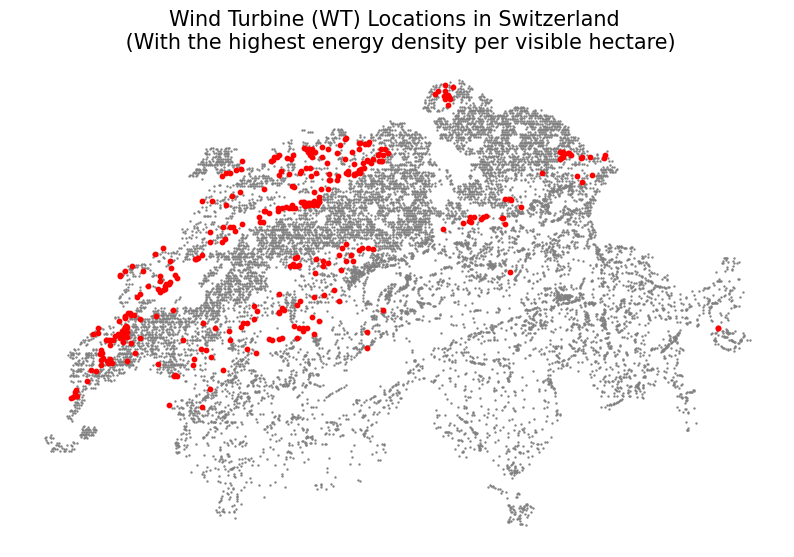

In [166]:
# Creating a new GeoDataFrame from selected locations
selected_locations_enr_dens_gdf = gpd.GeoDataFrame(geometry=selected_locations_enr_dens)

# Ploting the selected locations on the map
ax = gdf.plot(color='grey', markersize=0.5, figsize=(10,10))
selected_locations_enr_dens_gdf.plot(ax=ax, marker='o', color='red', markersize=10)

# Removing axis labels
ax.set_axis_off()

# Setting title
ax.set_title('Wind Turbine (WT) Locations in Switzerland \n (With the highest energy density per visible hectare)', size=15)

## Watermark for programming environment

In [ ]:
%load_ext watermark
%watermark -v -m -p numpy,pandas,matplotlib,seaborn,dbfread,ortools


The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.12.0

numpy     : 1.21.5
pandas    : 1.4.3
matplotlib: 3.7.1
seaborn   : 0.12.2
dbfread   : 2.0.7
ortools   : 9.6.2534

Compiler    : Clang 13.0.1 
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit

